In [4]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
%matplotlib inline

In [5]:
# set seed
np.random.seed(0)
tf.random.set_seed(0)

In [6]:
# read csv
df = pd.read_csv('../data/covid_19_data.csv', index_col='ObservationDate', parse_dates=True)

In [7]:
print(df)

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-01-22,1,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,2,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2020-01-22,3,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
2020-01-22,4,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,5,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2020-03-15,5886,Gibraltar,UK,2020-03-14T16:33:03,1.0,0.0,1.0
2020-03-15,5887,NaN,Uzbekistan,2020-03-15T18:20:19,1.0,0.0,0.0
2020-03-15,5888,Diamond Princess cruise ship,Australia,2020-03-14T02:33:04,0.0,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5890 entries, 2020-01-22 to 2020-03-15
Data columns (total 7 columns):
SNo               5890 non-null int64
Province/State    3575 non-null object
Country/Region    5890 non-null object
Last Update       5890 non-null object
Confirmed         5890 non-null float64
Deaths            5890 non-null float64
Recovered         5890 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 368.1+ KB


In [9]:
# groupby date
df = df.groupby('ObservationDate').sum()

In [10]:
print(df.shape)

(54, 4)

In [11]:
df_confirmed = df[['Confirmed']]
df_death = df[['Deaths']]
df_recovered = df[['Recovered']]

In [1073]:
print("Length of Data: \nConfirmed Datapoints {0} \nRecovered Datapoints {1} \nDeath Datapoints {2}".format(len(df_confirmed),len(df_recovered),len(df_death)))

Length of Data: 
Confirmed Datapoints 54 
Recovered Datapoints 54 
Death Datapoints 54


Confirmed Cases

In [389]:
print(df_confirmed)

,Confirmed
ObservationDate,
2020-01-22,555.0
2020-01-23,653.0
2020-01-24,941.0
2020-01-25,1438.0
2020-01-26,2118.0
2020-01-27,2927.0
2020-01-28,5578.0
2020-01-29,6165.0
2020-01-30,8235.0


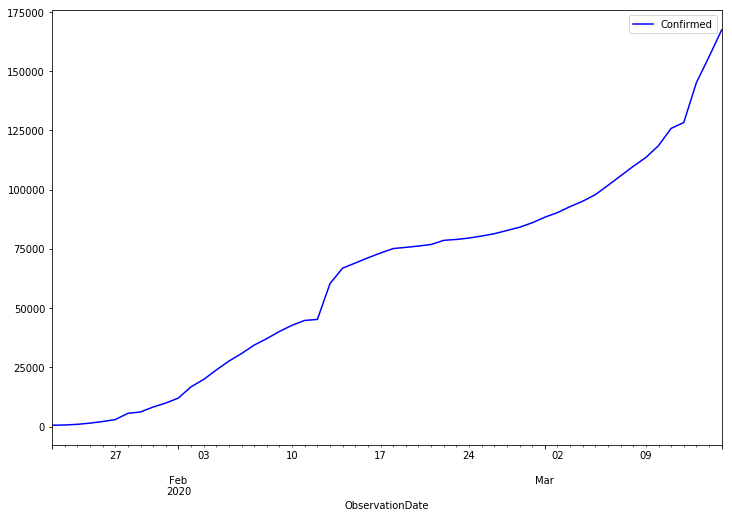

In [37]:
df_confirmed.plot(figsize=(12,8), color='B')

In [980]:
# Split the data into a train/test split
test_size = 2
test_ind = len(df_confirmed) - test_size

In [981]:
train = df_confirmed.iloc[:test_ind]
test = df_confirmed.iloc[test_ind:]

In [982]:
print(len(test))

2

In [983]:
# MinMaxScaler to scale the train and test sets into scaled versions.
scaler = MinMaxScaler()

In [984]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [985]:
scaled_train = scaler.transform(train)

In [986]:
scaled_test = scaler.transform(test)

In [987]:
# Create a TimeSeriesGenerator object
length = 1
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [1040]:
# Create a Keras Sequential Model with 700 LSTM units and a final Dense Layer
model = Sequential()
model.add(LSTM(700,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [1041]:
model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 700)               1965600   
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 701       
Total params: 1,966,301
Trainable params: 1,966,301
Non-trainable params: 0
_________________________________________________________________


In [1042]:
# Create a generator for the scaled test/validation set
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [1043]:
# Create an EarlyStopping callback based on val_loss
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [1044]:
# fit model
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Train for 51 steps, validate for 1 steps
Epoch 1/20
51/51 [==============================] - 5s 95ms/step - loss: 0.1391 - val_loss: 0.4244
Epoch 2/20
51/51 [==============================] - 2s 44ms/step - loss: 0.0301 - val_loss: 0.1226
Epoch 3/20
51/51 [==============================] - 2s 47ms/step - loss: 0.0226 - val_loss: 0.0799
Epoch 4/20
51/51 [==============================] - 2s 47ms/step - loss: 0.0138 - val_loss: 0.0727
Epoch 5/20
51/51 [==============================] - 3s 51ms/step - loss: 0.0084 - val_loss: 0.0230
Epoch 6/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0042 - val_loss: 0.0251
Epoch 7/20
51/51 [==============================] - 2s 48ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 8/20
51/51 [==============================] - 2s 43ms/step - loss: 9.8768e-04 - val_loss: 9.6428e-04
Epoch 9/20
51/51 [==============================] - 2s 43ms/step - loss: 5.7551e-04 - val_loss: 1.1789e-04
Epoch 10/20
51/51 [==============================] -

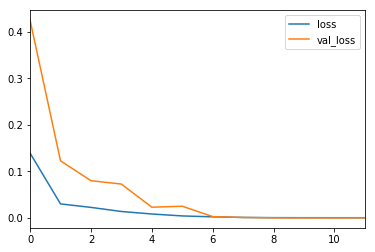

In [1045]:
# plot history of loss
loss = pd.DataFrame(model.history.history)
loss.plot()

In [1046]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to now include prediction and drop first value 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [1047]:
true_predictions = scaler.inverse_transform(test_predictions)

In [1048]:
test['Predictions'] = true_predictions

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1052]:
print(test)

                 Confirmed    Predictions
ObservationDate                          
2020-03-14        156099.0  155638.165474
2020-03-15        167447.0  168092.356818


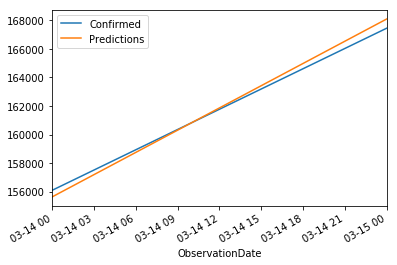

In [1050]:
test.plot()

In [1051]:
np.sqrt(mean_squared_error(test['Confirmed'],test['Predictions']))

560.737854521704

Retraining on full data

In [1053]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df_confirmed)

In [1054]:
length = 1
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [1055]:
model = Sequential()
model.add(LSTM(700,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit(generator,epochs=11)

Train for 53 steps
Epoch 1/11
53/53 [==============================] - 5s 95ms/step - loss: 0.1283
Epoch 2/11
53/53 [==============================] - 2s 43ms/step - loss: 0.0369
Epoch 3/11
53/53 [==============================] - 2s 45ms/step - loss: 0.0229
Epoch 4/11
53/53 [==============================] - 3s 50ms/step - loss: 0.0164
Epoch 5/11
53/53 [==============================] - 2s 46ms/step - loss: 0.0104
Epoch 6/11
53/53 [==============================] - 2s 45ms/step - loss: 0.0058
Epoch 7/11
53/53 [==============================] - 2s 43ms/step - loss: 0.0029
Epoch 8/11
53/53 [==============================] - 2s 43ms/step - loss: 0.0013
Epoch 9/11
53/53 [==============================] - 2s 45ms/step - loss: 6.6882e-04: 0s - loss: 8
Epoch 10/11
53/53 [==============================] - 2s 42ms/step - loss: 4.2209e-04
Epoch 11/11
53/53 [==============================] - 2s 43ms/step - loss: 3.4625e-04


In [1057]:
forecast = []

# replace period with whatever forecast length you want
period = 7

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(period):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop first value 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [1058]:
forecast = scaler.inverse_transform(forecast)

In [1059]:
df_confirmed

,Confirmed
ObservationDate,
2020-01-22,555.0
2020-01-23,653.0
2020-01-24,941.0
2020-01-25,1438.0
2020-01-26,2118.0
2020-01-27,2927.0
2020-01-28,5578.0
2020-01-29,6165.0
2020-01-30,8235.0


In [1060]:
forecast

array([[157645.86369514],
       [172824.71813869],
       [191708.00606942],
       [215772.48685241],
       [247409.82510948],
       [290816.94309282],
       [353783.46712971]])

In [1061]:
forecast_index = pd.date_range(start='2020-03-16',periods=period,freq='D')

In [1062]:
forecast_index

DatetimeIndex(['2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22'],
              dtype='datetime64[ns]', freq='D')

In [1063]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [1064]:
forecast_df

,Forecast
2020-03-16,157645.863695
2020-03-17,172824.718139
2020-03-18,191708.006069
2020-03-19,215772.486852
2020-03-20,247409.825109
2020-03-21,290816.943093
2020-03-22,353783.467130


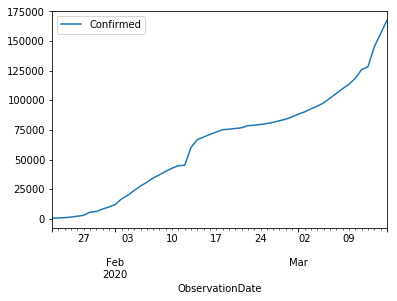

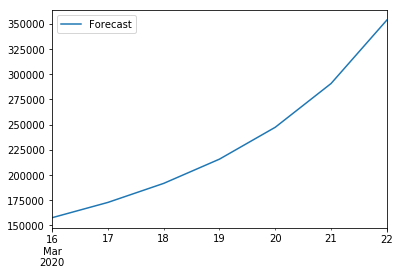

In [1065]:
df_confirmed.plot()
forecast_df.plot()

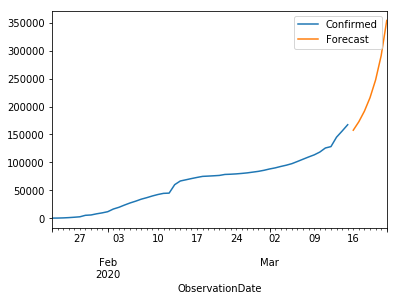

In [1069]:
ax = df_confirmed.plot()
forecast_df.plot(ax=ax)

In [1068]:
# save model
model.save('../model/confirmed_cases.h5')

Recovered Cases

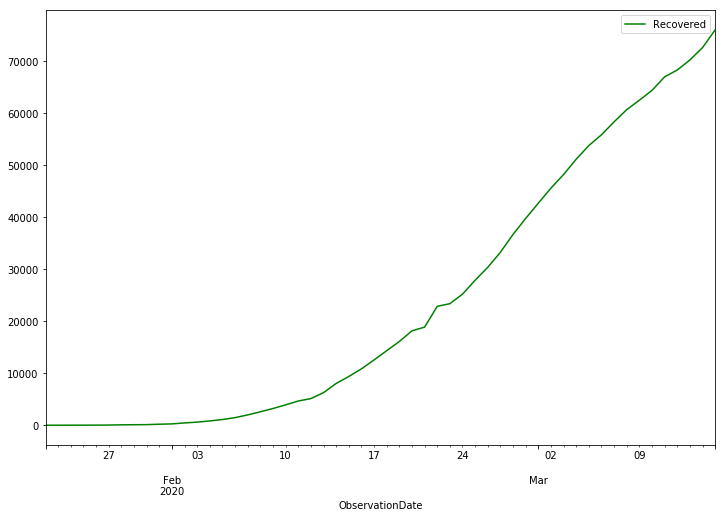

In [1070]:
df_recovered.plot(figsize=(12,8), color='G')

In [1074]:
df_recovered

,Recovered
ObservationDate,
2020-01-22,28.0
2020-01-23,30.0
2020-01-24,36.0
2020-01-25,39.0
2020-01-26,52.0
2020-01-27,61.0
2020-01-28,107.0
2020-01-29,126.0
2020-01-30,143.0


In [1248]:
# Split the data into a train/test split
test_size = 3
test_ind = len(df_recovered) - test_size

In [1249]:
train = df_recovered.iloc[:test_ind]
test = df_recovered.iloc[test_ind:]

In [1250]:
print(test)

                 Recovered
ObservationDate           
2020-03-13         70251.0
2020-03-14         72624.0
2020-03-15         76034.0


In [1251]:
# MinMaxScaler to scale the train and test sets into scaled versions.
scaler = MinMaxScaler()

In [1252]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [1253]:
scaled_train = scaler.transform(train)

In [1254]:
scaled_test = scaler.transform(test)

In [1255]:
# Create a TimeSeriesGenerator object
length = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [1256]:
# Create a Keras Sequential Model with 600 LSTM units and a final Dense Layer
model = Sequential()
model.add(LSTM(600,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [1257]:
model.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 600)               1444800   
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [1258]:
# Create a generator for the scaled test/validation set
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [1259]:
# Create an EarlyStopping callback based on val_loss
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [1260]:
# fit model
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Train for 49 steps, validate for 1 steps
Epoch 1/20
49/49 [==============================] - 6s 130ms/step - loss: 0.0672 - val_loss: 0.0131
Epoch 2/20
49/49 [==============================] - 3s 54ms/step - loss: 0.0036 - val_loss: 1.3488e-04
Epoch 3/20
49/49 [==============================] - 2s 51ms/step - loss: 2.7179e-04 - val_loss: 9.1921e-06
Epoch 4/20
49/49 [==============================] - 2s 51ms/step - loss: 1.4731e-04 - val_loss: 1.8724e-04
Epoch 5/20
49/49 [==============================] - 3s 57ms/step - loss: 9.6853e-05 - val_loss: 3.6592e-04


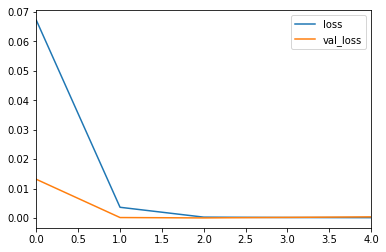

In [1261]:
# plot history of loss
loss = pd.DataFrame(model.history.history)
loss.plot()

In [1262]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to now include prediction and drop first value 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [1263]:
true_predictions = scaler.inverse_transform(test_predictions)

In [1264]:
test['Predictions'] = true_predictions

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1265]:
print(test)

                 Recovered   Predictions
ObservationDate                         
2020-03-13         70251.0  71146.281514
2020-03-14         72624.0  72951.581635
2020-03-15         76034.0  75433.857090


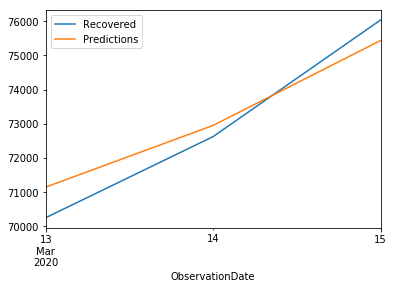

In [1266]:
test.plot()

In [1267]:
np.sqrt(mean_squared_error(test['Recovered'],test['Predictions']))

650.3871231655821

Retraining on full data

In [1268]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df_recovered)

In [1269]:
length = 2
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [1270]:
model = Sequential()
model.add(LSTM(600,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [1271]:
model.fit(generator,epochs=5)

Train for 52 steps
Epoch 1/5
52/52 [==============================] - 5s 96ms/step - loss: 0.0993
Epoch 2/5
52/52 [==============================] - 2s 47ms/step - loss: 0.0029
Epoch 3/5
52/52 [==============================] - 2s 46ms/step - loss: 2.6269e-04
Epoch 4/5
52/52 [==============================] - 2s 44ms/step - loss: 2.0296e-04
Epoch 5/5
52/52 [==============================] - 2s 47ms/step - loss: 1.1973e-04


In [1272]:
forecast = []

# replace period with whatever forecast length you want
period = 7

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(period):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop first value 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [1273]:
forecast = scaler.inverse_transform(forecast)

In [1274]:
df_recovered

,Recovered
ObservationDate,
2020-01-22,28.0
2020-01-23,30.0
2020-01-24,36.0
2020-01-25,39.0
2020-01-26,52.0
2020-01-27,61.0
2020-01-28,107.0
2020-01-29,126.0
2020-01-30,143.0


In [1275]:
forecast

array([[66892.08616066],
       [68071.18959427],
       [67697.70154333],
       [68215.02985716],
       [68191.10193682],
       [68467.6815033 ],
       [68551.7345314 ]])

In [1276]:
forecast_index = pd.date_range(start='2020-03-16',periods=period,freq='D')

In [1277]:
forecast_index

DatetimeIndex(['2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22'],
              dtype='datetime64[ns]', freq='D')

In [1278]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [1279]:
forecast_df

,Forecast
2020-03-16,66892.086161
2020-03-17,68071.189594
2020-03-18,67697.701543
2020-03-19,68215.029857
2020-03-20,68191.101937
2020-03-21,68467.681503
2020-03-22,68551.734531


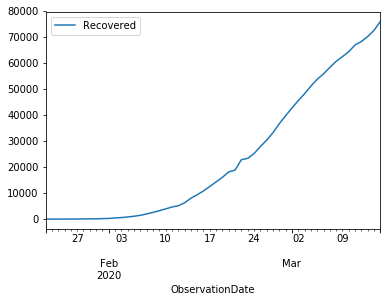

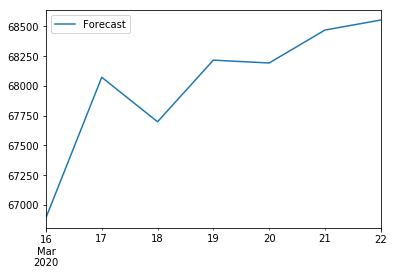

In [1282]:
df_recovered.plot()
forecast_df.plot()

(18330, 18343)

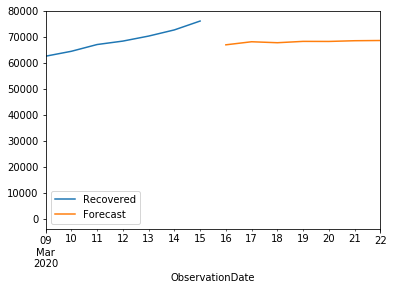

In [1284]:
ax = df_recovered.plot()
forecast_df.plot(ax=ax)
plt.xlim('2020-03-09','2020-03-22')

In [1285]:
# save model
model.save('../model/recovered_cases.h5')

Death Cases

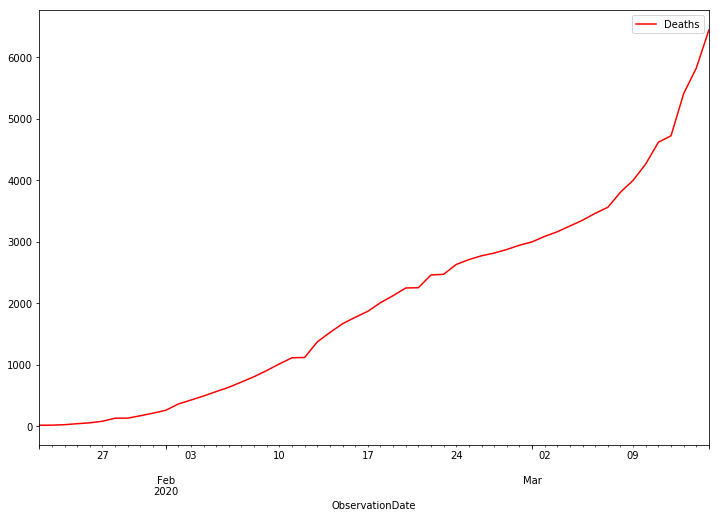

In [13]:
df_death.plot(figsize=(12,8), color='R')

In [12]:
df_death

,Deaths
ObservationDate,
2020-01-22,17.0
2020-01-23,18.0
2020-01-24,26.0
2020-01-25,42.0
2020-01-26,56.0
2020-01-27,82.0
2020-01-28,131.0
2020-01-29,133.0
2020-01-30,171.0


In [166]:
# Split the data into a train/test split
test_size = 2
test_ind = len(df_death) - test_size

In [167]:
train = df_death.iloc[:test_ind]
test = df_death.iloc[test_ind:]

In [168]:
print(test)

                 Deaths
ObservationDate        
2020-03-14       5819.0
2020-03-15       6440.0


In [169]:
# MinMaxScaler to scale the train and test sets into scaled versions.
scaler = MinMaxScaler()

In [170]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [171]:
scaled_train = scaler.transform(train)

In [172]:
scaled_test = scaler.transform(test)

In [173]:
# Create a TimeSeriesGenerator object
length = 1
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [174]:
# Create a Keras Sequential Model with 700 LSTM units and a final Dense Layer
model = Sequential()
model.add(LSTM(700,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [175]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 700)               1965600   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 701       
Total params: 1,966,301
Trainable params: 1,966,301
Non-trainable params: 0
_________________________________________________________________


In [176]:
# Create a generator for the scaled test/validation set
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [177]:
# Create an EarlyStopping callback based on val_loss
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [178]:
# fit model
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Train for 51 steps, validate for 1 steps
Epoch 1/20
51/51 [==============================] - 5s 90ms/step - loss: 0.1131 - val_loss: 0.5457
Epoch 2/20
51/51 [==============================] - 2s 44ms/step - loss: 0.0332 - val_loss: 0.2029
Epoch 3/20
51/51 [==============================] - 2s 47ms/step - loss: 0.0248 - val_loss: 0.1281
Epoch 4/20
51/51 [==============================] - 3s 56ms/step - loss: 0.0147 - val_loss: 0.1041
Epoch 5/20
51/51 [==============================] - 2s 44ms/step - loss: 0.0083 - val_loss: 0.0356
Epoch 6/20
51/51 [==============================] - 2s 44ms/step - loss: 0.0038 - val_loss: 0.0293
Epoch 7/20
51/51 [==============================] - 2s 46ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 8/20
51/51 [==============================] - 2s 44ms/step - loss: 5.8968e-04 - val_loss: 0.0018
Epoch 9/20
51/51 [==============================] - 2s 48ms/step - loss: 3.2848e-04 - val_loss: 3.3776e-04
Epoch 10/20
51/51 [==============================] - 2s 

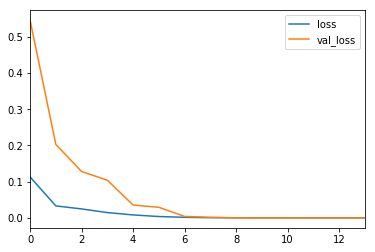

In [179]:
# plot history of loss
loss = pd.DataFrame(model.history.history)
loss.plot()

In [180]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to now include prediction and drop first value 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [181]:
true_predictions = scaler.inverse_transform(test_predictions)

In [182]:
test['Predictions'] = true_predictions

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [183]:
print(test)

                 Deaths  Predictions
ObservationDate                     
2020-03-14       5819.0  5863.758171
2020-03-15       6440.0  6422.180945


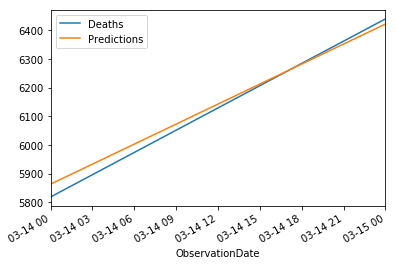

In [184]:
test.plot()

In [185]:
np.sqrt(mean_squared_error(test['Deaths'],test['Predictions']))

34.06473677687437

Retraining on Full Data

In [186]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df_death)

In [187]:
length = 1
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [188]:
model = Sequential()
model.add(LSTM(700,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [189]:
model.fit(generator,epochs=11)

Train for 53 steps
Epoch 1/11
53/53 [==============================] - 5s 103ms/step - loss: 0.1046 2s - 
Epoch 2/11
53/53 [==============================] - 3s 52ms/step - loss: 0.0395
Epoch 3/11
53/53 [==============================] - 3s 48ms/step - loss: 0.0257
Epoch 4/11
53/53 [==============================] - 3s 48ms/step - loss: 0.0182
Epoch 5/11
53/53 [==============================] - 3s 50ms/step - loss: 0.0111
Epoch 6/11
53/53 [==============================] - 3s 48ms/step - loss: 0.0057
Epoch 7/11
53/53 [==============================] - 2s 44ms/step - loss: 0.0025
Epoch 8/11
53/53 [==============================] - 3s 55ms/step - loss: 9.6801e-04
Epoch 9/11
53/53 [==============================] - 2s 47ms/step - loss: 4.2442e-04
Epoch 10/11
53/53 [==============================] - 3s 48ms/step - loss: 2.4566e-04
Epoch 11/11
53/53 [==============================] - 2s 46ms/step - loss: 1.9757e-04


In [190]:
forecast = []

# replace period with whatever forecast length you want
period = 7

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(period):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop first value 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [191]:
forecast = scaler.inverse_transform(forecast)

In [192]:
df_death

,Deaths
ObservationDate,
2020-01-22,17.0
2020-01-23,18.0
2020-01-24,26.0
2020-01-25,42.0
2020-01-26,56.0
2020-01-27,82.0
2020-01-28,131.0
2020-01-29,133.0
2020-01-30,171.0


In [193]:
forecast

array([[ 5981.15325117],
       [ 6701.4074235 ],
       [ 7622.90039682],
       [ 8841.53668284],
       [10525.74094629],
       [12991.6740315 ],
       [16893.87193298]])

In [194]:
forecast_index = pd.date_range(start='2020-03-16',periods=period,freq='D')

In [195]:
forecast_index

DatetimeIndex(['2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22'],
              dtype='datetime64[ns]', freq='D')

In [196]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [197]:
forecast_df

,Forecast
2020-03-16,5981.153251
2020-03-17,6701.407423
2020-03-18,7622.900397
2020-03-19,8841.536683
2020-03-20,10525.740946
2020-03-21,12991.674031
2020-03-22,16893.871933


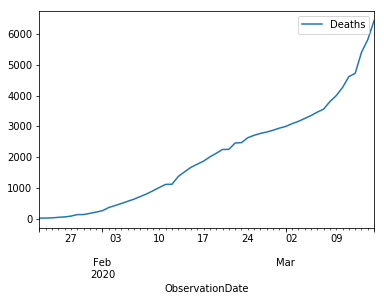

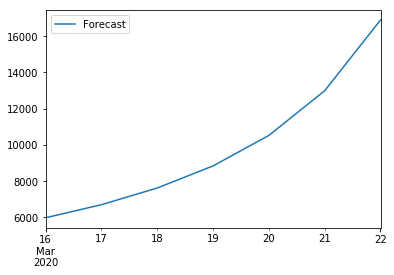

In [198]:
df_death.plot()
forecast_df.plot()

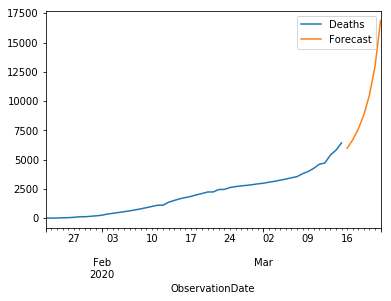

In [200]:
ax = df_death.plot()
forecast_df.plot(ax=ax)
#plt.xlim('2020-03-09','2020-03-22')

In [201]:
# save model
model.save('../model/death_cases.h5')

End Notes:-

Outcome 1: The Outbreak never really ends
According to researchers at World Health Organization(WHO), an average person with the new Corona Virus passes it to 1.4 to 2.5 people.

Outcome 1a: The Corona virus never disappears but becomes seasonal
If the virus becomes a permanent fixture in people, one possibility is that it winds up fluctuating with the seasons the way flu does. The flu virus survives better in a cool weather.

Outcome 2: Through Public-Health Interventions, the virus plays itself out
The Corona Virus is similar to SARS in many ways: a) Both are viruses that originated in bats and both jumped from animals to people. b) The two viruses share about 80% of their DNA. So the outcome could be similar to SARS too.

Outcome 3: Drug Companies manufacture could eventually manufacture a Vaccine or Cure. 
